# NLP on Curriculum Data


## Reading in data set

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import pprint
import random
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics import pairwise
from sklearn.cluster import KMeans, SpectralClustering
from scipy import sparse
import spacy
from wordcloud import WordCloud

pp = pprint.PrettyPrinter(indent=4)
nlp = spacy.load('en')

In [5]:
math_skills = pd.read_excel('Skills.xlsx', sheet_name='MA')

math_skills.head()

(1415, 5)


,Low Grade,High Grade,Subject,Course,Skill
0,K,K,Mathematics,Mathematics - K,count to 100 by ones and tens
1,K,K,Mathematics,Mathematics - K,"count forward by ones, beginning from a given ..."
2,K,K,Mathematics,Mathematics - K,write numerals from 0 to 20 and represent a nu...
3,K,K,Mathematics,Mathematics - K,demonstrate the relationship between numbers a...
4,K,K,Mathematics,Mathematics - K,count objects by stating number names in the s...


In [12]:
corpus = math_skills['Skill'].dropna()
print(math_skills.shape)
corpus.head()

(1415, 5)


0                        count to 100 by ones and tens
1    count forward by ones, beginning from a given ...
2    write numerals from 0 to 20 and represent a nu...
3    demonstrate the relationship between numbers a...
4    count objects by stating number names in the s...
Name: Skill, dtype: object

## Topic modeling

In [116]:
n_samples = 1415
n_features = 700
n_components = 20
n_top_words = 13


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += "; ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

def print_top_anchor_words(model, feature_names, n_top_words):
    words = {}
    for topic_idx, topic in enumerate(model.components_):
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            if feature_names[i] in words:
                words[feature_names[i]].append(topic_idx)
            else:
                words[feature_names[i]] = [topic_idx]
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += "; ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]
                             if words[feature_names[i]] == [topic_idx]])
        print(message)
    print()

def create_topic_wordcloud(model, feature_names, n_top_words, topic_idx):
    topic = model.components_[topic_idx]
    words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    p = list(topic)
    p.sort()
    p =  p[:-n_top_words - 1:-1]
    text = ' '.join(random.choices(words, weights=p, k=200))
    # Generate a word cloud image
    wordcloud = WordCloud(background_color='white', colormap=plt.get_cmap('GnBu')).generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

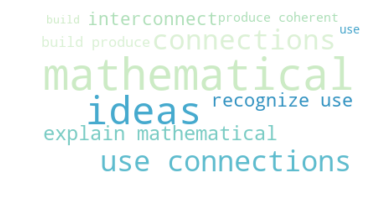

In [117]:
create_topic_wordcloud(nmf_fn, tfidf_feature_names, n_top_words, 3)

(20, 6219)


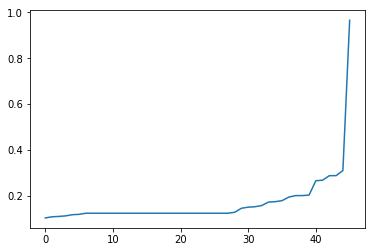

In [61]:
print(nmf_fn.components_.shape)
a = nmf_fn.components_[1]
a.sort()
plt.plot(a[a >= 0.1])
plt.show()

In [97]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   ngram_range=(1,2), 
                                   max_df=0.95, 
                                   min_df=2,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(corpus)

feature_names = tfidf_vectorizer.get_feature_names() 
tf_vectorizer = CountVectorizer(ngram_range=(1,2), 
                                max_df=0.95, 
                                min_df=2,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(corpus)

In [98]:
print("\nTopics in NMF model (Frobenius norm):")
nmf_fn = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5)
nmf_fn_topics = nmf_fn.fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf_fn, tfidf_feature_names, n_top_words)

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
nmf_kl = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5)
nmf_kl_topics = nmf_kl.fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf_kl, tfidf_feature_names, n_top_words)

print("\nTopics in LDA model:")
lda = LatentDirichletAllocation(n_components=n_components, max_iter=10,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda_topics = lda.fit_transform(tf)
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in NMF model (Frobenius norm):
Topic #0: equations; linear; linear equations; solve; variables; inequalities; variable; solutions; equations variables; equations inequalities; systems; represent; create
Topic #1: function; describes; domain; relationship; domain function; graph; relationship quantities; describes relationship; function describes; write function; rate change; change; function graph
Topic #2: add; subtract; add subtract; operations; properties operations; strategies; multiply; properties; numbers; addition; subtract multiply; digit; subtraction
Topic #3: mathematical ideas; ideas; mathematical; recognize use; use connections; connections; connections mathematical; use; explain mathematical; interconnect build; interconnect; produce coherent; build produce
Topic #4: functions; exponential; inverse functions; inverse; trigonometric; trigonometric functions; functions showing; logarithmic; exponential functions; logarithmic functions; showing; graph; exponential log

Topic #9: function; given; functions; line; graph; use; terms; angles; number; linear; determine; numbers; circle
Topic #10: use; model; probability; using; data; number; probabilities; fraction; interpret; plots; distributions; space; create
Topic #11: event; probability; cos; sin; sin cos; indicates; cos tan; tan; probability near; near; likelihood; unlikely; near indicates
Topic #12: units; use; proof; measurement; methods; rate; convert; metric; understand; reasoning; language; mathematical; ratio
Topic #13: properties; using; numbers; add; subtract; 10; explain; multiply; add subtract; subtraction; rational; operations; addition
Topic #14: functions; end; graph; showing; behavior; logarithmic; end behavior; exponential; exponential logarithmic; zeros; logarithmic functions; polynomial; functions showing
Topic #15: shorter; compare; directly; using tools; tools; longer shorter; longer; objects; length; capacity; basis; difference; weight
Topic #16: data; distribution; interpret; us

In [99]:
print_top_anchor_words(nmf_fn, tfidf_feature_names, n_top_words)

Topic #0: linear; linear equations; variables; inequalities; equations variables; equations inequalities; systems; create
Topic #1: describes; domain; domain function; describes relationship; function describes; write function; rate change; change; function graph
Topic #2: add; subtract; add subtract; operations; properties operations; multiply; addition; subtract multiply; digit; subtraction
Topic #3: mathematical ideas; ideas; recognize use; use connections; connections; connections mathematical; use; explain mathematical; interconnect build; interconnect; produce coherent; build produce
Topic #4: functions; exponential; inverse functions; inverse; trigonometric; trigonometric functions; functions showing; logarithmic; exponential functions; logarithmic functions; showing; exponential logarithmic
Topic #5: expression; reveal; equivalent; different; reveal explain; expression reveal; defined expression; equivalent forms; different equivalent; function defined; defined
Topic #6: distri

[0. 0. 0. ... 0. 0. 0.]


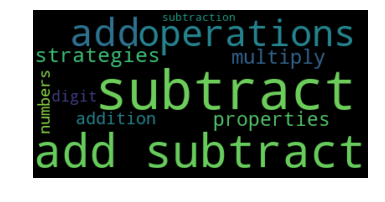

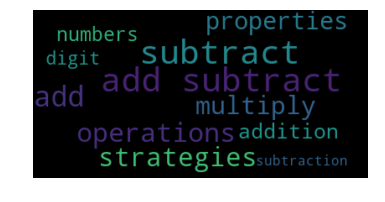

In [102]:
create_topic_wordcloud(nmf_fn, tfidf_feature_names, n_top_words, 2)

## Document similarity with spaCy

In [16]:
spacy_corpus = corpus.apply(nlp)
print(spacy_corpus.head())

0                (count, to, 100, by, ones, and, tens)
1    (count, forward, by, ones, ,, beginning, from,...
2    (write, numerals, from, 0, to, 20, and, repres...
3    (demonstrate, the, relationship, between, numb...
4    (count, objects, by, stating, number, names, i...
Name: Skill, dtype: object


In [17]:
spacy_similarity = np.zeros((len(spacy_corpus), len(spacy_corpus)))
for (i, doc) in enumerate(spacy_corpus):
    for (j, other_doc) in enumerate(spacy_corpus):
        spacy_similarity[i, j] = doc.similarity(other_doc)

In [18]:
def get_similar_phrases(pairwise_similarity, phrases, phrase_num):
    phrase = phrases[phrase_num]
    pairwise_phrase = (pairwise_similarity - np.eye(len(phrases)))[phrase_num].tolist()
    phrase_scores = [pair for pair in zip(range(0, len(phrases)), phrases, pairwise_phrase) if pair[2] > 0]
    phrase_scores = sorted(phrase_scores, key=lambda t: t[2] * -1)[:10]
    return (phrase, phrase_scores)

def get_least_similar_phrases(pairwise_similarity, phrases, phrase_num):
    phrase = phrases[phrase_num]
    pairwise_phrase = (pairwise_similarity - np.eye(len(phrases)))[phrase_num].tolist()
    phrase_scores = [pair for pair in zip(range(0, len(phrases)), phrases, pairwise_phrase) if pair[2] > 0]
    phrase_scores = sorted(phrase_scores, key=lambda t: t[2])[:10]
    return (phrase, phrase_scores)

In [19]:
(phrase, phrase_scores) = get_similar_phrases(spacy_similarity, corpus, 100)
print("phrase: %s\nsimilar phrases:" % phrase)
pp.pprint(phrase_scores)

phrase: compare two fractions with the same numerator or the same denominator by reasoning about their size; recognize that comparisons are valid only when the two fractions refer to the same whole and record the results of comparisons with the symbols >, =, or 

similar phrases:
[   (   140,
        'compare two decimals to hundredths by reasoning about their size. '
        'Recognize that comparisons are valid only when the two decimals refer '
        'to the same whole. Record the results of comparisons with the symbols '
        '>, =, or \n',
        0.9352144176874354),
    (   128,
        'compare two fractions with different numerators and different '
        'denominators (e.g., by using virtual fraction models, by creating '
        'common denominators or numerators, or by comparing to a benchmark '
        'fraction such as 1/2); recognize that comparisons are valid only when '
        'the two fractions refer to the same whole; record the results of '
        'compariso

In [20]:
(phrase, phrase_scores) = get_least_similar_phrases(spacy_similarity, corpus, 100)
print("phrase: %s\nsimilar phrases:" % phrase)
pp.pprint(phrase_scores)

phrase: compare two fractions with the same numerator or the same denominator by reasoning about their size; recognize that comparisons are valid only when the two fractions refer to the same whole and record the results of comparisons with the symbols >, =, or 

similar phrases:
[   (   906,
        "apply Rolle's Theorem and the Mean Value Theorem",
        0.3044504107163661),
    (   1241,
        'Students will apply Divisibility Properties, the Division Algorithm, '
        'and the Fundamental Theorem of Arithmetic.',
        0.34255031079128695),
    (   1247,
        'Students will apply the Chinese Remainder Theorem.',
        0.34350582511857153),
    (   1245,
        'Students will determine integral solutions to specified linear '
        'Diophantine Equations.',
        0.3670574904187923),
    (731, 'integrate vectors', 0.3788867294439584),
    (637, 'add and subtract vectors', 0.4000450198854213),
    (1277, 'add and subtract vectors', 0.4000450198854213),
    (   696

## Clustering documents based on topic

In [22]:
def cluster_phrases(clusterer, topic_model, corpus):
    cluster_model = clusterer.fit(topic_model)
    cluster_topics = cluster_model.predict(topic_model)
    score_clusters = cluster_model.transform(topic_model).min(axis=1)
    clustered_corpus = [list(phrase) for phrase in zip(cluster_topics, corpus, score_clusters)]
    return (cluster_model, clustered_corpus)

def get_cluster_phrases(clustered_corpus, cluster_num):
    phrases = [phrase for phrase in clustered_corpus if phrase[0] == cluster_num]
    phrases_sorted = sorted(phrases, key=lambda t: t[2])[:10]
    return phrases_sorted

In [23]:
kmeans, kmeans_corpus = cluster_phrases(KMeans(n_clusters=50, random_state=0), lda_topics, corpus)
get_cluster_phrases(kmeans_corpus, 1)

[[1, 'find inverse functions', 0.03914723410763986],
 [1, 'find inverse functions', 0.03914723410763986],
 [1, 'find inverse functions', 0.03914723410763986],
 [1, 'find inverse functions', 0.03914723410763986],
 [1, 'determine the limit of a sequence', 0.048497423485482645],
 [1, 'investigate transformations of functions', 0.048497423691121755],
 [1,
  'determine where a function fails to be differentiable',
  0.048497423960865337],
 [1,
  'identify types of discontinuities graphically and analytically',
  0.07441247397204413],
 [1, 'calculate limits using algebra', 0.07441248882235074],
 [1,
  'find the angular speed and the magnitude of the acceleration of a particle moving along a curve',
  0.07441248940242845]]